# Transformer model for Nepali Sentiment Analysis

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [4]:
import sys
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '../../../'))
sys.path.append(project_root)

### Data Loading and Preprocessing

In [5]:
DATASET_PATH = os.path.join(
    project_root,
    'nepali_sentiment_analysis',
    'dataset',
    'processed',
    'combined_cleaned_data.csv'
)

In [6]:
df = pd.read_csv(DATASET_PATH)
print("Dataset Loaded Successfully!")
df.head()

Dataset Loaded Successfully!


,Sentiment,Sentences
0,0,पुन निर्वाचन गरे यस्तै हुने हो
1,0,निर्वाचन कति गरिरहने
2,0,शासन व्यवस्था चुनाव पध्दति फेर्नु एउटा उपचार हो
3,0,क्या अचम्मकाे नगरपालिका डाेजरम्यान बालेनकाे
4,0,प्युठान नगरपालिका नेपाल स्वयंसेवक राष्ट्रिय सम...


## Embedding


In [7]:
from utils.embedding import Embeddings

word_vectors = Embeddings().load_vector()
embedding_dim = word_vectors.vector_size
print(f"Loaded embeddings with dimension: {embedding_dim}")

Loaded embeddings with dimension: 300


In [8]:
# Sentence to embedding conversion with improved handling
max_length = 120


def sentence_to_embedding(sentence):
    tokens = sentence.split()
    embeddings = [
        word_vectors[token] 
        if token in word_vectors 
        else np.zeros(embedding_dim)
        for token in tokens
    ]
    if len(embeddings) > max_length:
        embeddings = embeddings[:max_length]
    else:
        embeddings += [np.zeros(embedding_dim)] * (max_length - len(embeddings))
    return np.array(embeddings)


embedded_sentences = np.array(
    df["Sentences"].apply(sentence_to_embedding).tolist()
)
sentiments = df["Sentiment"].values

print(f"Embedded Sentences Shape: {embedded_sentences.shape}")

Embedded Sentences Shape: (43636, 120, 300)


---

### Data Preparation for Training

In [9]:
from torch.utils.data import DataLoader, TensorDataset, random_split

# Convert data to tensors
embedded_sentences_tensor = torch.tensor(embedded_sentences, dtype=torch.float32)
sentiments_tensor = torch.tensor(sentiments, dtype=torch.long)

In [10]:
# Create dataset and split
dataset = TensorDataset(embedded_sentences_tensor, sentiments_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [11]:
# Create DataLoader for batch processing
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [12]:
# Print dataset sizes
print(f"Training Set Size: {train_size}")
print(f"Validation Set Size: {val_size}")

Training Set Size: 34908
Validation Set Size: 8728


### Model Initialization and Hyperparameters

In [16]:
# Model parameters
d_model = embedding_dim
num_heads = 6
num_layers = 6
num_classes = 3
d_ff = 1200
dropout = 0.2
max_len = max_length

In [17]:
from nepali_sentiment_analysis.transformer_model import SentimentTransformer

In [18]:
model = SentimentTransformer(
    d_model, 
    num_heads, 
    num_layers, 
    num_classes, 
    d_ff, 
    max_len, 
    dropout
).to(device)

In [19]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [20]:
# Define weighted loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [21]:
# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=3, verbose=True
)

In [22]:
# Early stopping parameters
early_stopping_patience = 5
best_val_loss = float('inf')
no_improvement_epochs = 0

### Training Loop with Early Stopping

In [23]:
num_epochs = 50
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_train_loss = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    # Validation phase
    model.eval()
    total_val_loss, correct_predictions = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()

    # Calculate metrics
    train_loss = total_train_loss / len(train_loader)
    val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct_predictions / len(val_loader.dataset)

    # Save metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print epoch summary
    print(
        f"Epoch {epoch + 1}/{num_epochs}, "
        f"Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, "
        f"Validation Accuracy: {val_accuracy:.4f}"
    )

    # Update scheduler and check early stopping
    scheduler.step(val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_epochs = 0
        torch.save(model.state_dict(), "../../models/best_model.pth")
        print("Validation loss improved. Model saved.")
    else:
        no_improvement_epochs += 1
        if no_improvement_epochs >= early_stopping_patience:
            print("Early stopping triggered.")
            break

Epoch 1/50, Train Loss: 1.3257, Validation Loss: 0.7554, Validation Accuracy: 0.6980
Validation loss improved. Model saved.
Epoch 2/50, Train Loss: 0.7151, Validation Loss: 0.7115, Validation Accuracy: 0.7036
Validation loss improved. Model saved.
Epoch 3/50, Train Loss: 0.6613, Validation Loss: 0.7102, Validation Accuracy: 0.7135
Validation loss improved. Model saved.
Epoch 4/50, Train Loss: 0.6232, Validation Loss: 0.7379, Validation Accuracy: 0.7210
Epoch 5/50, Train Loss: 0.5946, Validation Loss: 0.6829, Validation Accuracy: 0.7156
Validation loss improved. Model saved.
Epoch 6/50, Train Loss: 0.5774, Validation Loss: 0.7221, Validation Accuracy: 0.7021
Epoch 7/50, Train Loss: 0.5503, Validation Loss: 0.6961, Validation Accuracy: 0.7183
Epoch 8/50, Train Loss: 0.5289, Validation Loss: 0.7120, Validation Accuracy: 0.7250
Epoch 9/50, Train Loss: 0.5088, Validation Loss: 0.6923, Validation Accuracy: 0.7222
Epoch 10/50, Train Loss: 0.3913, Validation Loss: 0.7605, Validation Accuracy: 

### Training Visualization

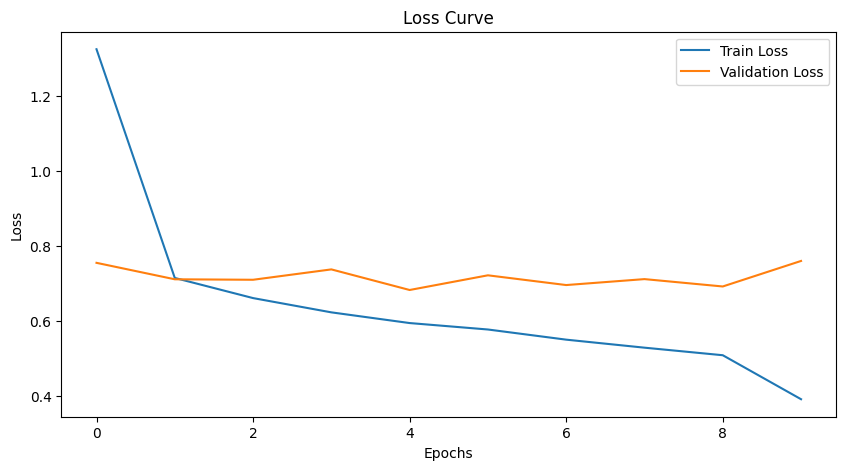

In [24]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

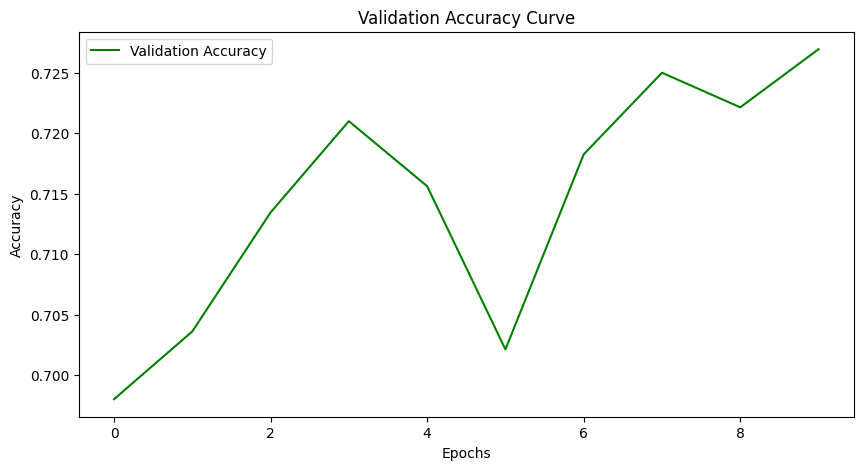

In [25]:
# Plot validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label="Validation Accuracy", color="green")
plt.title("Validation Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Evaluation

In [26]:
# Load the best model
model.load_state_dict(torch.load("../../models/best_model.pth"))
model.eval()
print("Best model loaded for evaluation.")

Best model loaded for evaluation.


In [27]:
# Evaluate model on validation set
predictions, actuals = [], []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        actuals.extend(labels.cpu().numpy())

In [28]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)

In [29]:
# Calculate metrics
f1 = f1_score(actuals, predictions, average="weighted")
precision = precision_score(actuals, predictions, average="weighted")
recall = recall_score(actuals, predictions, average="weighted")
conf_matrix = confusion_matrix(actuals, predictions)

In [30]:
# Display metrics
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("\nClassification Report:")
print(classification_report(actuals, predictions,
      target_names=["Neutral", "Positive", "Negative"]))

F1 Score: 0.7158
Precision: 0.7198
Recall: 0.7156

Classification Report:
              precision    recall  f1-score   support

     Neutral       0.67      0.77      0.71      2636
    Positive       0.76      0.68      0.72      3223
    Negative       0.72      0.71      0.71      2869

    accuracy                           0.72      8728
   macro avg       0.72      0.72      0.72      8728
weighted avg       0.72      0.72      0.72      8728



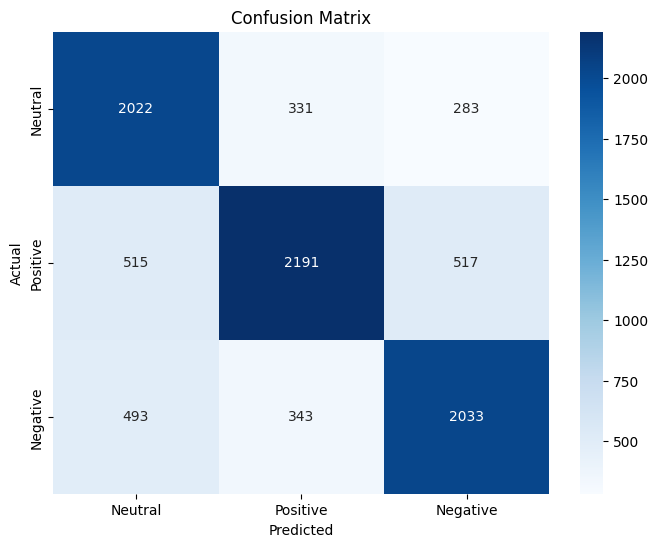

In [31]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=["Neutral", "Positive", "Negative"],
    yticklabels=["Neutral", "Positive", "Negative"]
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Saving the Model

In [32]:
current_path = os.path.abspath(os.path.join(current_dir, "..", ".."))

# Check if 'models' directory exists, if not, create it
models_dir = os.path.join(current_path, "models")
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Save the model
model_save_path = os.path.join(models_dir, "sentiment_transformer_model.pth")
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to c:\Users\Suyash Shrestha\Personal\_Nepali_news_project\News-algorithm\news_algorithms\nepali_sentiment_analysis\models\sentiment_transformer_model.pth


## Loading the Model

In [33]:
# Load the model for inference
loaded_model = SentimentTransformer(
    d_model, num_heads, num_layers, num_classes, d_ff, max_len, dropout
)
loaded_model.load_state_dict(torch.load(model_save_path))
loaded_model.to(device)
loaded_model.eval()
print("Model loaded successfully for inference!")

Model loaded successfully for inference!


In [34]:
# Sample sentences for inference
sentences = ["म आजको खाना खान गरें।", "मलाई यो गाउँ मन पर्छ।", "म यो गाडी नचलाउन चाहन्छु"]

In [35]:
from utils.preprocess import preprocess

In [36]:
processed_sentences = [preprocess(sentence)[0] for sentence in sentences]
embedded_sentences = np.array([
    sentence_to_embedding(sentence) 
    for sentence 
    in processed_sentences
])

In [37]:
# Convert to tensor
embedded_sentences_tensor = torch.tensor(embedded_sentences, dtype=torch.float32).to(
    device
)

In [38]:
# Perform inference
predictions = []

with torch.no_grad():
    for inputs in embedded_sentences_tensor:
        inputs = inputs.unsqueeze(0)
        outputs = loaded_model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.append(predicted.item())

In [39]:
labels_dict = {0: "Neutral", 1: "Positive", 2: "Negative"}

In [40]:
# Display predictions
for sentence, prediction in zip(sentences, predictions):
    print(f"Sentence: {sentence}")
    print(f"Predicted Sentiment: {labels_dict[prediction]}\n")

Sentence: म आजको खाना खान गरें।
Predicted Sentiment: Neutral

Sentence: मलाई यो गाउँ मन पर्छ।
Predicted Sentiment: Neutral

Sentence: म यो गाडी नचलाउन चाहन्छु
Predicted Sentiment: Neutral



In [41]:
text = "म खुसी छु"
processed_text = preprocess(text)[0]
embedded_text = sentence_to_embedding(processed_text)
embedded_text_tensor = (
    torch.tensor(embedded_text, dtype=torch.float32).unsqueeze(0).to(device)
)

# Perform inference
with torch.no_grad():
    outputs = loaded_model(embedded_text_tensor)
    _, predicted = torch.max(outputs, 1)

# Display prediction
print(f"Text: {text}")
print(f"Predicted Sentiment: {labels_dict[predicted.item()]}")

Text: म खुसी छु
Predicted Sentiment: Positive
